In [1]:
using PyCall
using Distances
using StatsBase
using LinearAlgebra
using JuMP
using Gurobi
using CSV
using Distances
using PyPlot
using SparseArrays
using Printf

In [2]:
py"""
import numpy as np
import cv2

class RootSIFT:
    def __init__(self):
        self.extractor = cv2.xfeatures2d.SIFT_create()

    def compute(self, image, kps, eps=1e-7):
        (kps, descs) = self.extractor.compute(image, kps)
        if len(kps) == 0:
            return ([], None)

        descs /= (descs.sum(axis=1, keepdims=True) + eps)
        descs = np.sqrt(descs)
        return (kps, descs)
def rootSIFT(img_path):
    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    (kps, descs) = sift.detectAndCompute(gray, None)
    rs = RootSIFT()
    (kps, descs) = rs.compute(gray, kps)
    pos = [np.array([x.pt[0], x.pt[1]]) for x in kps]
    return np.array(pos)

"""

img1_path = "../data/test/test_1.jpg"
img2_path = "../data/test/test_2.jpg"

descs1 = py"rootSIFT"(img1_path);
descs2 = py"rootSIFT"(img2_path);

In [3]:
function cleaning(original)
    res_dict = Dict()
    for i in 1:size(original, 1)
        res_dict[hash(original[i,:])] = original[i,:]
    end
    
    vals = collect(values(res_dict))
    output = zeros(size(vals,1), 2)
    for i in 1:size(vals,1)
        output[i,:] = [vals[i][1],vals[i][2]]
    end
    
    return output
end

cleaning (generic function with 1 method)

In [4]:
P_points = cleaning(descs1);
Q_points = cleaning(descs2);

In [5]:
cost = pairwise(Euclidean(), P_points, Q_points; dims=1)

29×30 Array{Float64,2}:
 17.1347   46.6309   33.0987   26.0223   …  50.3459    8.10832  34.1529 
 52.0808   10.8986   34.4478   29.8458      25.7254   49.1058   37.6856 
 40.8556   42.8731   11.6735   17.3149      56.9207   44.7755   12.9967 
 29.1332   43.1141    1.43056   7.10291     55.3089   33.1111    4.62736
 12.6395   63.711    25.5388   26.1198      72.4677   22.8413   23.562  
 24.1144   36.0246   28.4803   20.3033   …  41.0251   17.9129   30.4416 
 69.1836   12.7581   57.1431   51.3037       8.66254  63.3852   60.3861 
 12.1564   55.256    18.3324   17.7326      64.3669   20.1571   17.0281 
  7.00818  59.4808   24.8863   23.509       67.4629   16.8839   23.6105 
 52.0706    9.93888  35.0591   30.2323      24.6301   48.8685   38.3027 
 30.705    37.9359    6.59092   5.13886  …  50.1596   33.0772    9.81896
 37.1704   34.1041   11.5563   11.2918      47.4716   38.8814   14.6328 
 24.2601   39.5624   33.8381   25.8472      42.5566   15.9307   35.5589 
  ⋮                        

In [6]:
P = ones(size(P_points,1));
Q = ones(size(Q_points,1));

In [8]:
solCount = 1000
# m = JuMP.direct_model(Gurobi.Optimizer(PoolSearchMode=2, PoolSolutions=solCount, SolutionNumber=0,PoolGap = 0.001))
m = JuMP.direct_model(Gurobi.Optimizer(PoolSearchMode=2, PoolSolutions=solCount, SolutionNumber=0))

@variable(m, X[axes(cost,1), axes(cost,2)] ≥ 0, Int)
@objective(m, Min, cost ⋅ X)
@constraint(m,sum(X) .== min(sum(P), sum(Q)))
@constraint(m, X * ones(Int, length(Q)) .<= P)
@constraint(m, X'ones(Int, length(P)) .<= Q);
optimize!(m)
solution_pool = zeros(solCount, length(P),length(Q))
cnt = 0
for i in 0:(solCount-1)
    try
        setparam!(m.moi_backend.inner,"SolutionNumber", i)
        
        xn = Gurobi.get_dblattrarray(m.moi_backend.inner, "Xn", 1, length(X))
        xn_val = Gurobi.get_dblattr(m.moi_backend.inner, "PoolObjVal")
        if(round(xn_val,digits=10) != round(obj, digits=10))
            println(xn_val,' ', obj)
            break
        end
        default = zeros(length(P),length(Q))
        for i in 0:length(P)-1
            default[i+1,:] = xn[(i*length(Q))+1:(i+1)*length(Q)]
        end
        solution_pool[i+1,:,:] = default
        cnt+=1
    catch 
        break
    end
end
sol_pool = deepcopy(solution_pool[1:cnt,:,:]);

Optimize a model with 60 rows, 870 columns and 2610 nonzeros
Variable types: 0 continuous, 870 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+01]
Presolve time: 0.01s
Presolved: 60 rows, 870 columns, 2610 nonzeros
Variable types: 0 continuous, 870 integer (870 binary)

Root relaxation: objective 2.621755e+02, 85 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     262.1754747  262.17547  0.00%     -    0s
Optimal solution found at node 0 - now completing solution pool...
     0     0          -    0       262.17547  262.17547  0.00%     -    0s
     0     0          -    0       262.17547  262.17547  0.00%     -    0s
     0     2          -    0       262.17547  262.17547  0.00%     -    0s
 40553  7083  

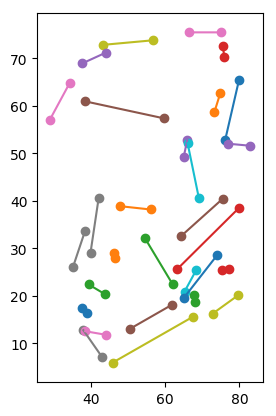

In [13]:
solOther = sparse(value.(X))
for (x,y,v) in zip(findnz(solOther)...)
    x_pos = [P_points'[:,x][1], Q_points'[:,y][1]]
    y_pos = [P_points'[:,x][2], Q_points'[:,y][2]]
    subplot(122)
    scatter(x_pos, y_pos)
    plot(x_pos, y_pos)
    
end